### Import packages

In [14]:
import pandas as pd
import pickle
import numpy as np
import pyLDAvis

import matplotlib.pyplot as plt
import seaborn as sns

# sklearn 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics.pairwise import cosine_similarity

# gensim
from gensim import corpora, models, similarities, matutils

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

### Read information from articles

In [15]:
with open('AWS_pickle/Initial_Model/article_df_AWS_lemma.pkl', 'rb') as f:
    article_df = pickle.load(f)

In [16]:
# Convert the text to all lower case.
article_list = article_df['content'].str.lower()

In [17]:
with open('AWS_pickle/New_Model/article_countvec_lemma.pkl', 'rb') as f:
    count_vectorizer = pickle.load(f)

with open('AWS_pickle/New_Model/doc_word.pkl', 'rb') as f:
    doc_word = pickle.load(f)
    
with open('AWS_pickle/New_Model/doc_word_T.pkl', 'rb') as f:
    doc_word_T = pickle.load(f)

In [18]:
# Visualize the matrix (for examination only, dataframe not used later)
pd.DataFrame(doc_word.toarray(), count_vectorizer.get_feature_names()).shape

(4627, 142570)

### LDA Modeling (Topic Modeling)

In [19]:
# Convert sparse matrix of counts to a gensim corpus
# corpus = matutils.Sparse2Corpus(doc_word)

# corpora.MmCorpus.serialize('corpus.mm', corpus)

corpus = corpora.MmCorpus('AWS_pickle/New_Model/corpus.mm')

/anaconda3/envs/metis_3.6/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [20]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [21]:
# Pickle the LDA model as 'LDA_model.pkl'

with open('AWS_pickle/New_Model/LDA/LDA_model_24.pkl', 'rb') as f:
    lda = pickle.load(f)

## Note: the LSA Model and HDP Models below were run for comparison only. As the topics output by the LDA model were more understandable, the LDA model was used for all analysis. Code was maintained for those interested in reproducing the topics examined.

### LSA Modeling (Matrix Dimensions)

In [8]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
lsa = TruncatedSVD(15)
doc_topic = lsa.fit_transform(doc_word_T)
lsa.explained_variance_ratio_

array([0.10052089, 0.04180058, 0.02171874, 0.01601865, 0.01387187,
       0.01260164, 0.01096739, 0.00952229, 0.00859109, 0.00812319,
       0.00795296, 0.00741871, 0.0073094 , 0.00708268, 0.00657723])

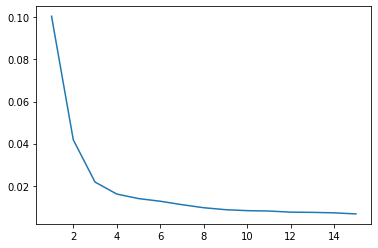

In [9]:
sns.lineplot(range(1,16), lsa.explained_variance_ratio_)

In [10]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = range(15),
             columns = count_vectorizer.get_feature_names())

In [11]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [12]:
display_topics(lsa, count_vectorizer.get_feature_names(), 10)


Topic  0
trump, people, president, like, new, year, u, trumps, time, clinton

Topic  1
trump, trumps, president, clinton, donald, campaign, republican, donald trump, cruz, election

Topic  2
people, like, clinton, think, know, trump, thing, im, going, woman

Topic  3
trump, company, trumps, business, like, president, know, think, hotel, organization

Topic  4
u, s, u s, think, comey, know, im, russian, russia, going

Topic  5
police, officer, attack, shooting, told, investigation, black, comey, shot, man

Topic  6
president, house, court, comey, white house, law, white, investigation, administration, obama

Topic  7
clinton, company, new, email, comey, clintons, year, woman, hillary, time

Topic  8
school, student, woman, court, child, s, u, state, university, education

Topic  9
percent, school, comey, s, u s, student, u, trump, police, officer

Topic  10
year, sentence, house, month, party, republican, prison, vote, district, intent

Topic  11
state, sentence, school, people, prison

### HDP

**Rationale**: HDP provides a "weight" for each topic. By using the HDP model, we can determine how relevant each topic is and establish a cutoff weight for topics.

In [14]:
hdp = models.HdpModel(corpus=corpus, id2word=id2word, random_state = 42)

In [9]:
list(zip(hdp.print_topics(), hdp.hdp_to_lda()[0]))

[((0,
   '0.020*trump + 0.008*clinton + 0.007*president + 0.007*state + 0.006*campaign + 0.006*republican + 0.006*party + 0.006*people + 0.005*trumps + 0.005*new'),
  0.12378228713559371),
 ((1,
   '0.009*like + 0.008*year + 0.007*people + 0.007*time + 0.006*new + 0.004*way + 0.004*make + 0.004*day + 0.004*life + 0.004*thing'),
  0.12251633417277162),
 ((2,
   '0.008*u + 0.007*s + 0.006*u s + 0.006*people + 0.006*state + 0.005*attack + 0.005*year + 0.005*country + 0.005*president + 0.005*government'),
  0.11176707472143553),
 ((3,
   '0.009*trump + 0.007*year + 0.006*company + 0.006*new + 0.005*u + 0.005*president + 0.005*state + 0.005*percent + 0.005*s + 0.005*government'),
  0.08440624288957588),
 ((4,
   '0.015*police + 0.008*officer + 0.006*people + 0.005*told + 0.005*year + 0.004*state + 0.004*time + 0.004*case + 0.004*law + 0.004*city'),
  0.08359325689850525),
 ((5,
   '0.009*people + 0.008*school + 0.007*student + 0.007*woman + 0.006*year + 0.005*like + 0.004*new + 0.004*time +

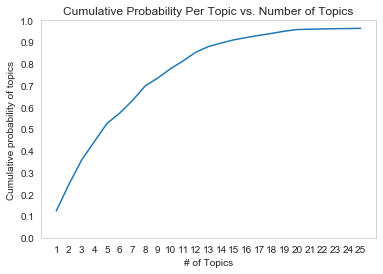

In [12]:
sns.set_style("whitegrid")
plot = sns.lineplot(range(1,26), np.cumsum(hdp.hdp_to_lda()[0][:25]));
plt.ylim(0.0, 1.0)
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.xticks(range(1,26))
plot.grid(False)
plot.set(ylabel = 'Cumulative probability of topics', xlabel = '# of Topics')
plot.set_title('Cumulative Probability Per Topic vs. Number of Topics');

plt.savefig('Images/HDP.png', format="png", bbox_inches='tight', transparent = True, dpi = 300);

## Beginning of Analysis

### Assigning topics to data

In [ ]:
lda_corpus = lda[corpus]

# Store the documents' topic vectors in a dictionary
lda_dict = [dict(doc) for doc in lda_corpus]

In [23]:
# Load previously pickled dictionary
with open('local_pickle/lda_dict.pkl', 'rb') as f:
    lda_dict = pickle.load(f)

In [24]:
# Generate dataframe of topics
topic_df = pd.DataFrame(lda_dict)
topic_df = topic_df.fillna(value = 0)

In [25]:
lda.print_topics(25)

[(0,
  '0.025*"court" + 0.013*"case" + 0.012*"law" + 0.009*"justice" + 0.009*"judge" + 0.009*"federal" + 0.008*"state" + 0.008*"order" + 0.007*"supreme" + 0.007*"supreme court"'),
 (1,
  '0.013*"clinton" + 0.011*"new" + 0.009*"m" + 0.007*"hillary" + 0.007*"year" + 0.007*"people" + 0.006*"york" + 0.006*"new york" + 0.005*"like" + 0.005*"woman"'),
 (2,
  '0.014*"sanders" + 0.011*"game" + 0.010*"clinton" + 0.008*"team" + 0.007*"party" + 0.007*"win" + 0.007*"democratic" + 0.007*"year" + 0.006*"player" + 0.006*"state"'),
 (3,
  '0.009*"people" + 0.009*"like" + 0.008*"year" + 0.007*"time" + 0.006*"new" + 0.005*"make" + 0.005*"woman" + 0.005*"work" + 0.005*"way" + 0.004*"company"'),
 (4,
  '0.013*"medium" + 0.011*"twitter" + 0.010*"trump" + 0.009*"facebook" + 0.008*"people" + 0.007*"speech" + 0.006*"new" + 0.005*"social" + 0.005*"like" + 0.004*"social medium"'),
 (5,
  '0.029*"police" + 0.016*"officer" + 0.010*"black" + 0.009*"shooting" + 0.007*"people" + 0.007*"student" + 0.006*"university" 

In [26]:
# Visualize topics for analysis: see Model_Topics_evaluation.ipynb

with open('local_pickle/vis_24.pkl', 'rb') as f:
    vis = pickle.load(f)
pyLDAvis.save_html(vis, 'pyLDAvis.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.061536 -0.047530       1        1   4.206120
1     -0.015176  0.014144       2        1   0.918745
2     -0.047284  0.092361       3        1   4.120118
3     -0.120060 -0.004452       4        1   7.526975
4     -0.001217  0.022103       5        1   2.881059
5     -0.047191 -0.044608       6        1   2.533426
6      0.048077  0.116872       7        1   8.885525
7      0.030022 -0.039417       8        1   7.226401
8      0.115024  0.048442       9        1   4.938270
9      0.037581 -0.067103      10        1   1.876015
10    -0.007180  0.050303      11        1   2.609795
11     0.037265  0.014850      12        1   2.301965
12     0.025794 -0.001928      13        1   1.627340
13    -0.053601 -0.032576      14        1   3.514920
14     0.042003 -0.013118      15        1   3.000221
15     0.082688  0.013903      16        1   3.766870
16    -0.037572 -0.114195      17        1   5.417081
17    -0.020658 -0.025724      18        1   2.321665
18    -0.082996  0.042880      19        1   6.713342
19     0.097269 -0.053527      20        1   5.008830
20     0.023453  0.073389      21        1   3.074275
21    -0.036743 -0.080791      22        1   3.063081
22    -0.136930  0.042261      23        1  10.397208
23     0.005898 -0.006539      24        1   2.070760, topic_info=     Category           Freq     Term          Total  loglift  logprob
13    Default  369369.000000    trump  369369.000000  30.0000  30.0000
267   Default   74105.000000   police   74105.000000  29.0000  29.0000
1322  Default  109879.000000  clinton  109879.000000  28.0000  28.0000
86    Default   61458.000000    court   61458.000000  27.0000  27.0000
652   Default   62833.000000   school   62833.000000  26.0000  26.0000
...       ...            ...      ...            ...      ...      ...
957   Topic24    3263.747559    group   84579.718750   0.6224  -5.5781
3     Topic24    3922.046387      new  202978.500000  -0.0692  -5.3944
340   Topic24    3296.972900     like  182315.984375  -0.1355  -5.5680
31    Topic24    2808.014404    issue   55341.851562   0.8962  -5.7285
462   Topic24    2530.302979    local   29609.009766   1.4175  -5.8326

[1435 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4284      1  0.118208  abortion
4284      2  0.004860  abortion
4284      3  0.014990  abortion
4284      4  0.008282  abortion
4284      5  0.002738  abortion
...     ...       ...       ...
2410     20  0.003314     yorks
2410     21  0.011047     yorks
2410     22  0.018780     yorks
2410     23  0.159076     yorks
2410     24  0.027617     yorks

[24259 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [27]:
# 24 Topics determined after examining topic words for model from 10-40 topics. Topic names determined manaully from examination of
# most probable words

topic_dict = {0: 'law', 1: 'hillary_clinton', 2: 'sports', 3: 'lifestyle', 4: 'social_media', \
              5: 'police_shooting', 6: 'presidential_election', 7: 'business', 8: 'trump_administration', \
              9: 'north_korea', 10: 'presidents', 11: 'abortion', 12: 'immigration', 13: 'education', \
              14: 'european_union', 15: 'clinton_email_fbi', 16: 'crime', 17: 'climate_change', 18: 'opinion', \
              19: 'US_policy', 20: 'health_care', 21: 'islamic_state', 22: 'pop_culture', \
              23: 'gun_rights'}

In [28]:
# Create feature df by combining the cleaned article dataframe and the topic dataframe.
feature_df = pd.concat([article_df[['id', 'publication', 'title']], topic_df], axis = 1)
feature_df = feature_df.rename(columns = topic_dict)
feature_df['best_topic'] = feature_df.iloc[:,3:].idxmax(axis=1)

In [29]:
# Create pickle file for use in other Jupyter notebooks.
# with open('local_pickle/feature_df.pkl', 'wb') as f:
#     pickle.dump(feature_df, f)

### Readability Index

In [30]:
import spacy
import en_core_web_sm
from spacy_readability import Readability

nlp = en_core_web_sm.load()
nlp.add_pipe(Readability())

In [31]:
# Load pickled readability information from Readability_Score_AWS.py. List contains lists of readability scores for each
# article within the corpus
with open('AWS_pickle/metric_list_AWS.pkl', 'rb') as f:
    metric_list=pickle.load(f)

In [32]:
# Note the order of the metric list is: FK_grade, FK_reading_ease, Dale_chall, smog, coleman_liau, automated, forcast
metric_col = [m[3] for m in metric_list]
feature_df['grade_level'] = metric_col

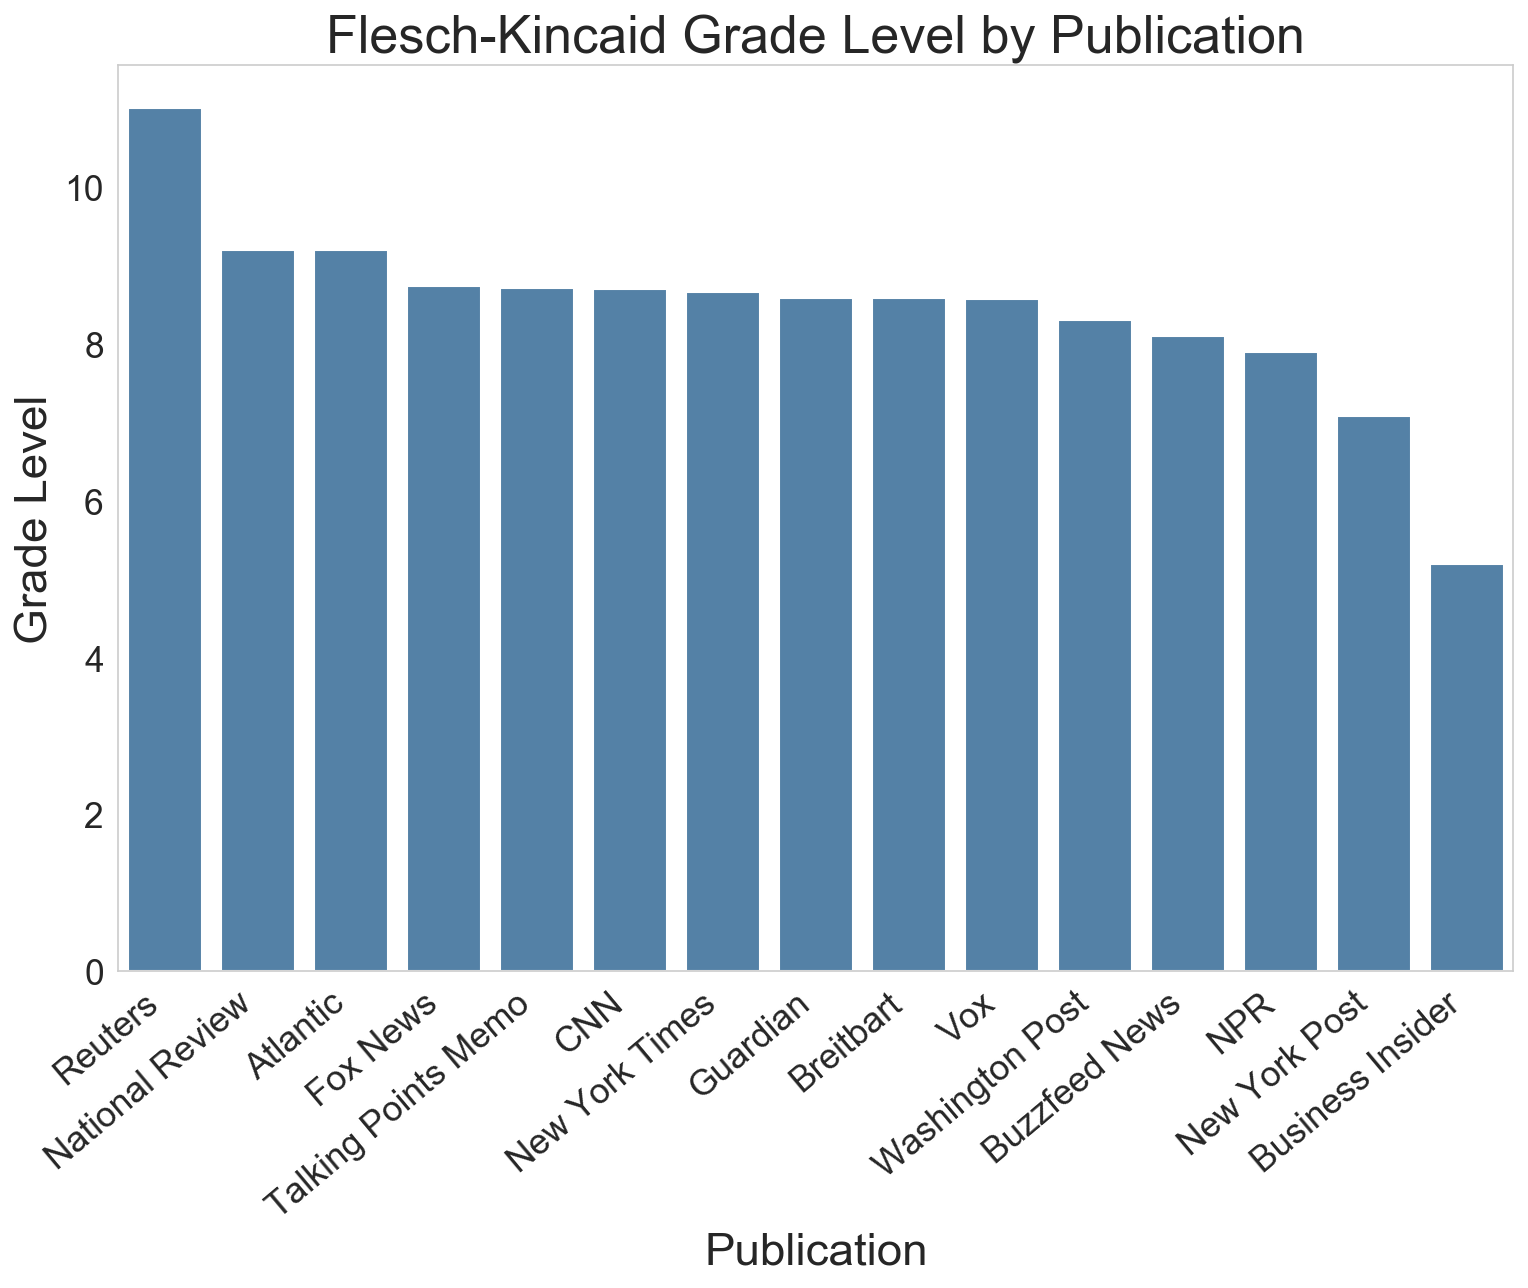

In [57]:
# Plot Flesch-Kincaid
metric_col = [m[0] for m in metric_list]
feature_df['grade_level'] = metric_col

read_df = (feature_df
           .groupby('publication')['grade_level']
           .mean()
           .reset_index()
           .sort_values('grade_level', ascending = False))

plt.figure(dpi = 150)
b = sns.barplot(read_df['publication'], read_df['grade_level'], color = 'steelblue')
b.set_xlabel('Publication', fontsize = 22)
b.set_ylabel('Grade Level', fontsize = 22)
b.set_xticklabels(labels = b.get_xticklabels(), fontsize = 17, ha = 'right', rotation=40)
b.set_yticklabels(labels = np.arange(0, 12, 2), fontsize = 17)
b.set_title('Flesch-Kincaid Grade Level by Publication', fontsize = 25)
b.grid(False);

plt.savefig('Images/FK.png', format="png", bbox_inches='tight', transparent = True, dpi = 300)

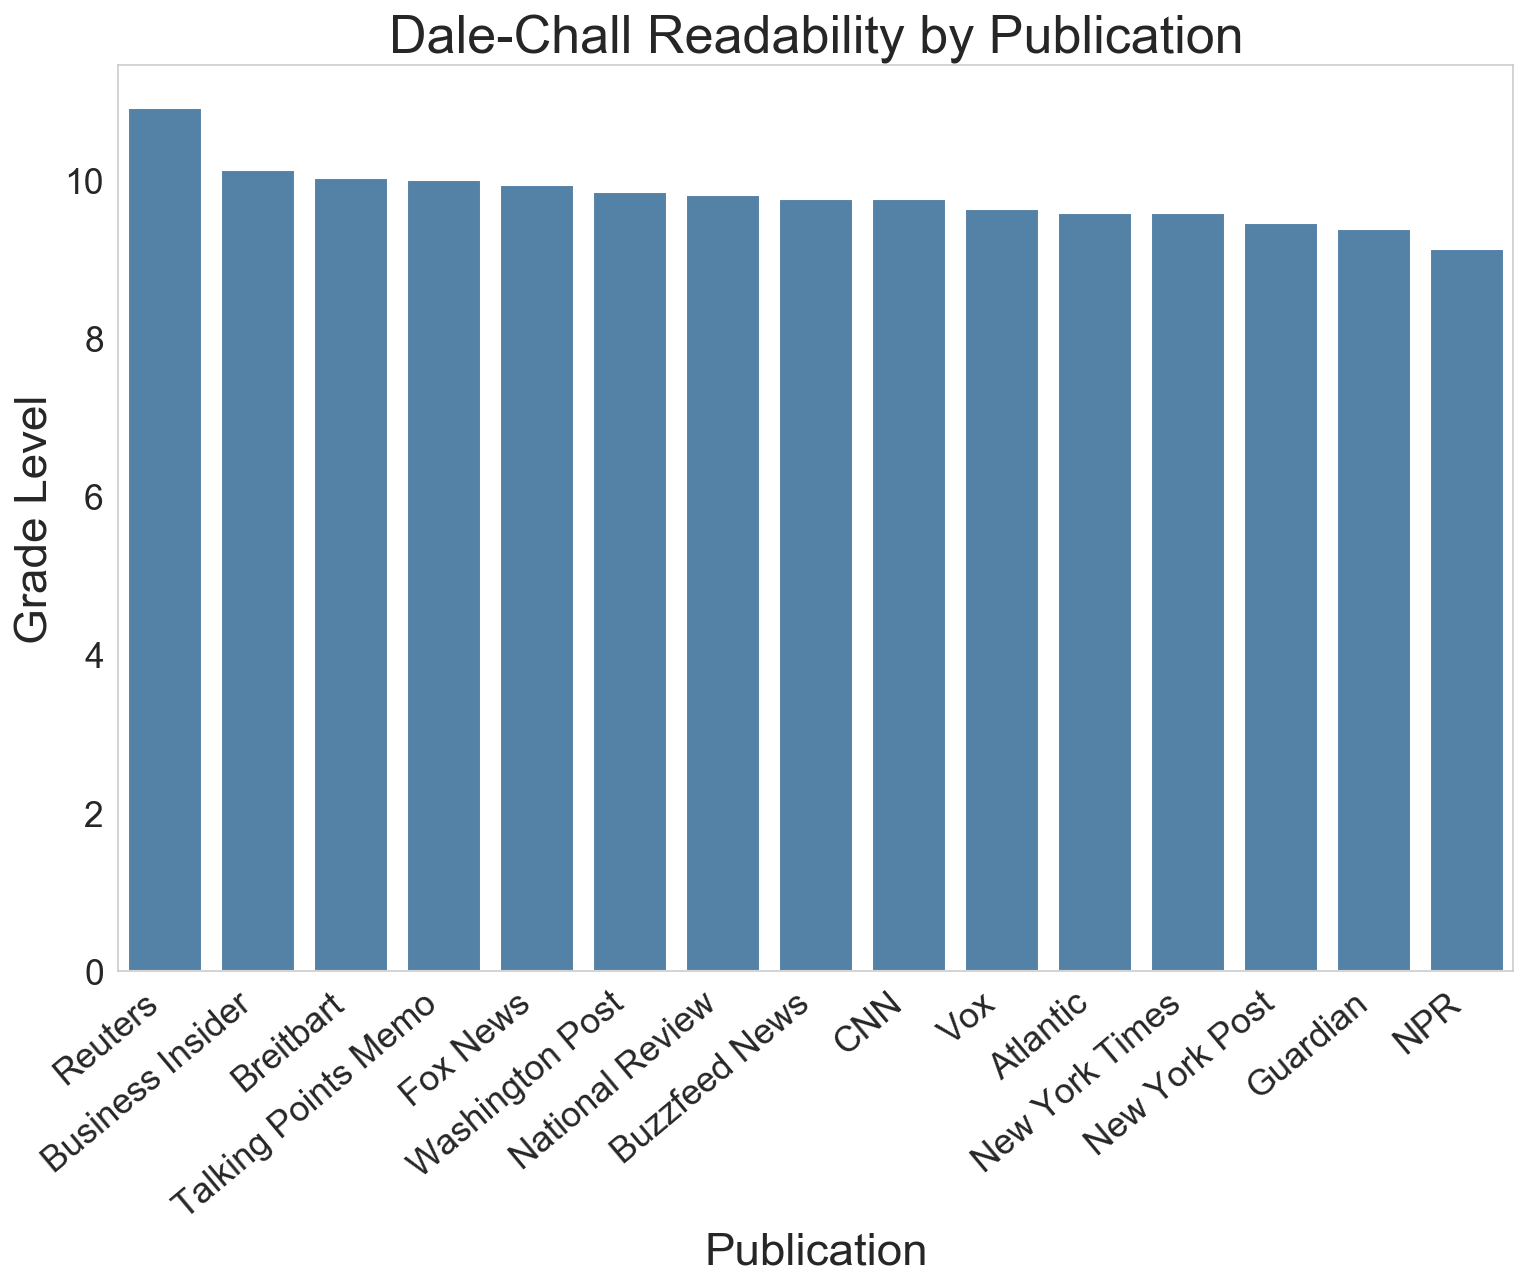

In [53]:
# Plot Dale-Chall Readability
metric_col = [m[2] for m in metric_list]
feature_df['grade_level'] = metric_col

read_df = (feature_df
           .groupby('publication')['grade_level']
           .mean()
           .reset_index()
           .sort_values('grade_level', ascending = False))

plt.figure(dpi = 150)
b = sns.barplot(read_df['publication'], read_df['grade_level'], color = 'steelblue')
b.set_xlabel('Publication', fontsize = 22)
b.set_ylabel('Grade Level', fontsize = 22)
b.set_xticklabels(labels = b.get_xticklabels(), fontsize = 17, ha = 'right', rotation=40)
b.set_yticklabels(labels = np.arange(0, 12, 2), fontsize = 17)
b.set_title('Dale-Chall Readability by Publication', fontsize = 25)
b.grid(False);

plt.savefig('Images/DC.png', format="png", bbox_inches='tight', transparent = True, dpi = 300)

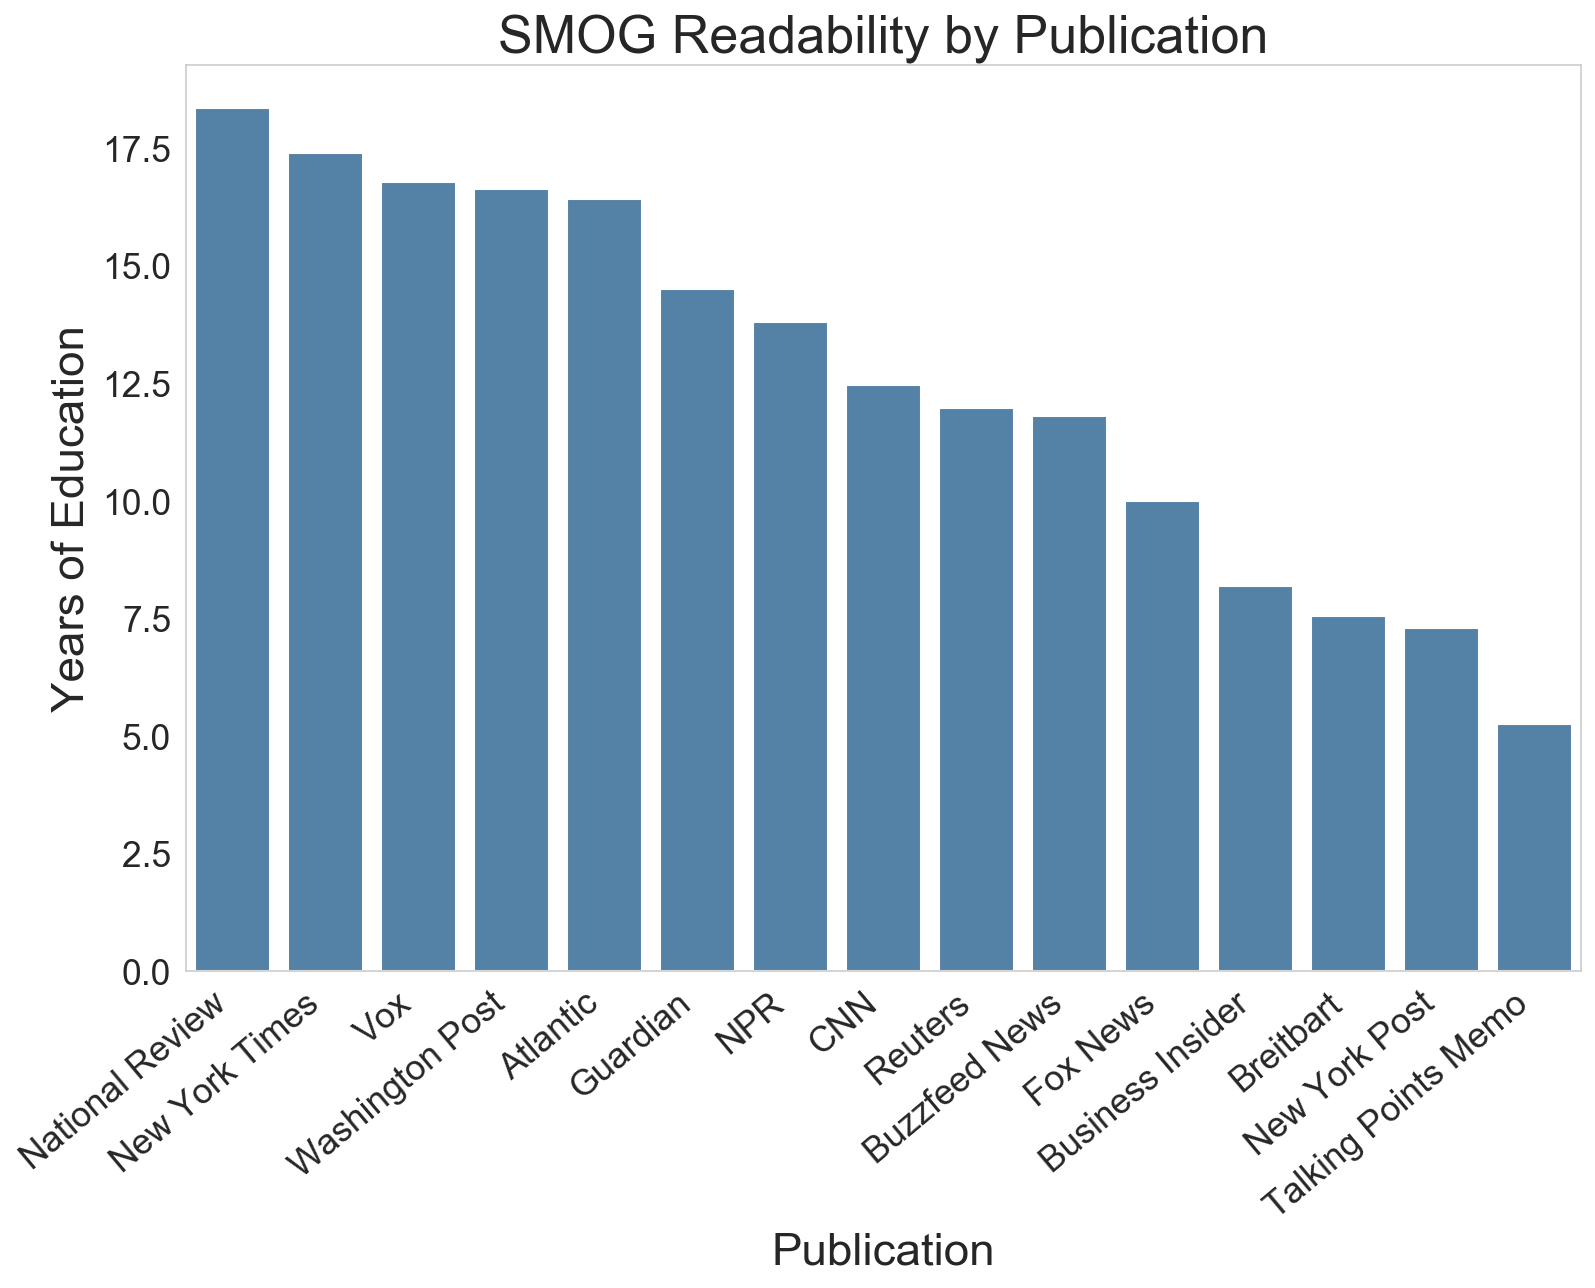

In [56]:
# Plot SMOG readability
metric_col = [m[3] for m in metric_list]
feature_df['grade_level'] = metric_col

read_df = (feature_df
           .groupby('publication')['grade_level']
           .mean()
           .reset_index()
           .sort_values('grade_level', ascending = False))

plt.figure(dpi = 150)
b = sns.barplot(read_df['publication'], read_df['grade_level'], color = 'steelblue')
b.set_xlabel('Publication', fontsize = 22)
b.set_ylabel('Years of Education', fontsize = 22)
b.set_xticklabels(labels = b.get_xticklabels(), fontsize = 17, ha = 'right', rotation=40)
b.set_yticklabels(labels = np.arange(0, 20, 2.5), fontsize = 17)

b.set_title('SMOG Readability by Publication', fontsize = 25)
b.grid(False);

plt.savefig('Images/SMOG.png', format="png", bbox_inches='tight', transparent = True, dpi = 300)

### Topic Analysis

In [36]:
# Display most common article topic for each publication
feature_df.groupby('publication').agg(lambda x:x.value_counts().index[0])['best_topic']

publication
Atlantic                             opinion
Breitbart              presidential_election
Business Insider                    business
Buzzfeed News                          crime
CNN                                    crime
Fox News               presidential_election
Guardian                         pop_culture
NPR                              pop_culture
National Review                      opinion
New York Post                    pop_culture
New York Times                   pop_culture
Reuters                             business
Talking Points Memo    presidential_election
Vox                              pop_culture
Washington Post        presidential_election
Name: best_topic, dtype: object

In [37]:
# Find 3 closest topics for each topic to group the topics into categories:
# Note that using the cosine similarity is only partially effective; after examining the visualization and
# considering the cosine similarities below, topics were manually determined.
topic_similarities = cosine_similarity(lda.get_topics())

close_topic_list = list(topic_dict.values())
close_topic_dict = {}

for t in range(len(topic_similarities)):
    close_topics = sorted(range(len(topic_similarities[t])), key=lambda i: topic_similarities[t][i])[-5:-1]
    close_topics = [topic_dict.get(e, '') for e in close_topics]
    close_topic_dict[close_topic_list[t]] = close_topics

pd.DataFrame(close_topic_dict)

,law,hillary_clinton,sports,lifestyle,social_media,police_shooting,presidential_election,business,trump_administration,north_korea,...,european_union,clinton_email_fbi,crime,climate_change,opinion,US_policy,health_care,islamic_state,pop_culture,gun_rights
0,clinton_email_fbi,pop_culture,lifestyle,education,lifestyle,opinion,immigration,european_union,US_policy,islamic_state,...,opinion,US_policy,lifestyle,pop_culture,hillary_clinton,north_korea,trump_administration,hillary_clinton,sports,opinion
1,immigration,sports,opinion,hillary_clinton,opinion,presidents,presidents,hillary_clinton,presidents,european_union,...,hillary_clinton,social_media,hillary_clinton,opinion,presidents,trump_administration,presidents,lifestyle,hillary_clinton,islamic_state
2,hillary_clinton,social_media,pop_culture,opinion,presidents,hillary_clinton,trump_administration,lifestyle,abortion,business,...,social_media,trump_administration,islamic_state,hillary_clinton,pop_culture,european_union,lifestyle,crime,opinion,hillary_clinton
3,gun_rights,lifestyle,hillary_clinton,pop_culture,hillary_clinton,crime,abortion,US_policy,presidential_election,US_policy,...,US_policy,hillary_clinton,police_shooting,lifestyle,lifestyle,islamic_state,hillary_clinton,US_policy,lifestyle,law


In [38]:
# After examining the distances above, the topics, and the visualization in Model_Topic_Evaluation,
# determined the following categories:
cat_list = ['law_order', 'election_politics', 'daily_life', 'daily_life', 'daily_life', 'law_order', \
            'election_politics', 'markets', 'domestic_politics', 'global_politics', 'domestic_politics', \
            'social', 'social', 'policy', 'global_politics', 'election_politics', 'law_order', 'policy', \
            'daily_life', 'policy', 'policy', 'global_politics', 'daily_life', 'policy']

list(topic_dict.values())

cat_dict = dict(zip(list(topic_dict.values()), cat_list))
cat_dict

{'law': 'law_order',
 'hillary_clinton': 'election_politics',
 'sports': 'daily_life',
 'lifestyle': 'daily_life',
 'social_media': 'daily_life',
 'police_shooting': 'law_order',
 'presidential_election': 'election_politics',
 'business': 'markets',
 'trump_administration': 'domestic_politics',
 'north_korea': 'global_politics',
 'presidents': 'domestic_politics',
 'abortion': 'social',
 'immigration': 'social',
 'education': 'policy',
 'european_union': 'global_politics',
 'clinton_email_fbi': 'election_politics',
 'crime': 'law_order',
 'climate_change': 'policy',
 'opinion': 'daily_life',
 'US_policy': 'policy',
 'health_care': 'policy',
 'islamic_state': 'global_politics',
 'pop_culture': 'daily_life',
 'gun_rights': 'policy'}

In [39]:
# Add in categories for each topic
feature_df['category'] = feature_df['best_topic']
feature_df = feature_df.replace({"category": cat_dict})

In [40]:
# For each publication, calculate the "rate" for that topic:
cat_df = feature_df.groupby(['category','publication']).agg({'id':'count'}).reset_index()
cat_df['pub_total'] = cat_df.groupby('publication')['id'].transform('sum')
cat_df = cat_df.rename(columns = {'id': 'cat_total'})
cat_df['rate'] = cat_df['cat_total'] / cat_df['pub_total']

test_df = cat_df[cat_df['pub_total'] > 10000]
test_df.head(15)

,category,publication,cat_total,pub_total,rate
1,daily_life,Breitbart,5188,23781,0.218157
4,daily_life,CNN,3205,11488,0.278987
7,daily_life,NPR,5668,11992,0.472648
9,daily_life,New York Post,8616,17493,0.492540
11,daily_life,Reuters,410,10710,0.038282
14,daily_life,Washington Post,2786,11114,0.250675
16,domestic_politics,Breitbart,2620,23781,0.110172
19,domestic_politics,CNN,1060,11488,0.092270
22,domestic_politics,NPR,517,11992,0.043112
24,domestic_politics,New York Post,566,17493,0.032356


In [41]:
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

def p_value_calc(row_1, row_2):
    """Calculates the p-value of a two-tailed test between two publications.
    
    Parameters: row_1 and row_2 are the rows of the dataframe with publication information; cat_total is the total articles in a category
                for the publication and pub_total is the total articles for the publication overall. Rate is the cat_total/pub_total;
                the "success rate" for the experiment, or the rate at which articles are within the category.
    
    Output: generates a p-value (float).
    
    """
    
    p_A, p_B = (row_1['rate'], row_2['rate'])
    p = (row_1['cat_total'] + row_2['cat_total'])/(row_1['pub_total'] + row_2['pub_total'])
    variance = p*(1-p)/row_1['cat_total'] + p*(1-p)/row_2['cat_total']

    abs_z = abs(p_A - p_B)/np.sqrt(variance)

    p_value = 2*(1-norm.cdf(abs_z))
    return p_value

In [42]:
def cat_p_value_calc(df):
    """Within a category, calculate all combinations of p-values for 6 publications.
    
    Parameters: df is the dataframe containing the publications, article counts, and rates for each category.
    
    Output: a list of p-values of length 15 (one per comparison made).
    """
    p_list = []
    for p in range(0, 5):
        for e in range(p, 5):
            p_list.append(p_value_calc(df.iloc[p,:], df.iloc[e + 1]))

    return p_list

In [43]:
# Holm (Holm-Bonferroni) correction chosen for multi-hypothesis testing vs. the default Holm-sidak (hs) as hs 
# assumes the individual tests performed are independent. Holm does not make this assumption but offers less
# power.

def df_p_value_calc(df):
    """Using p-values provided, determines the alpha level required for a multi-hypothesis test and determines whether each p-value
    meets the necessary threshold. This function uses the Holm-Bonferroni method to address the multiplicity problem.
    
    Parameters: df is the dataframe containing the publications, article counts, and rates for each category.
    
    Output: a list of tuples, where the first element of the tuple is the category name and the second is a tuple containing: an array of
    Booleans (True if the alt. hypothesis is accepted, False if not), an array of floats (p-values corrected for multiple tests), the
    corrected alpha under Sidak, and the corrected alpha under Bonferroni.
    """
    
    result_list = []
    
    for c in df['category'].unique():
        mask = df['category'] == c
        cat_df = df[mask]
        p_values = cat_p_value_calc(cat_df)
        result_list.append((c, multipletests(p_values, method = 'holm')))
        
    return result_list

In [44]:
# Under a multiple-hypothesis method, ALL comparisons must output true to be considered valid. In this case, only daily_life was
# significant.

df_p_value_calc(test_df)

[('daily_life',
  (array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True]),
   array([8.17532708e-10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          2.92934873e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          2.65416307e-02, 2.65416307e-02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
   0.0034137129465903193,
   0.0033333333333333335)),
 ('domestic_politics',
  (array([False,  True,  True,  True, False,  True,  True,  True, False,
          False, False,  True, False,  True,  True]),
   array([6.46080121e-01, 1.00384223e-05, 4.75538942e-09, 8.47289564e-05,
          1.00000000e+00, 2.26047433e-03, 7.40998064e-06, 9.86747981e-03,
          1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 3.71462093e-04,
          8.66705504e-01, 4.76629424e-07, 2.26047433e-03]),
   0.0034137129465903193,
   0.0033333333333333335)),
 ('election_politics',
  (array([ T

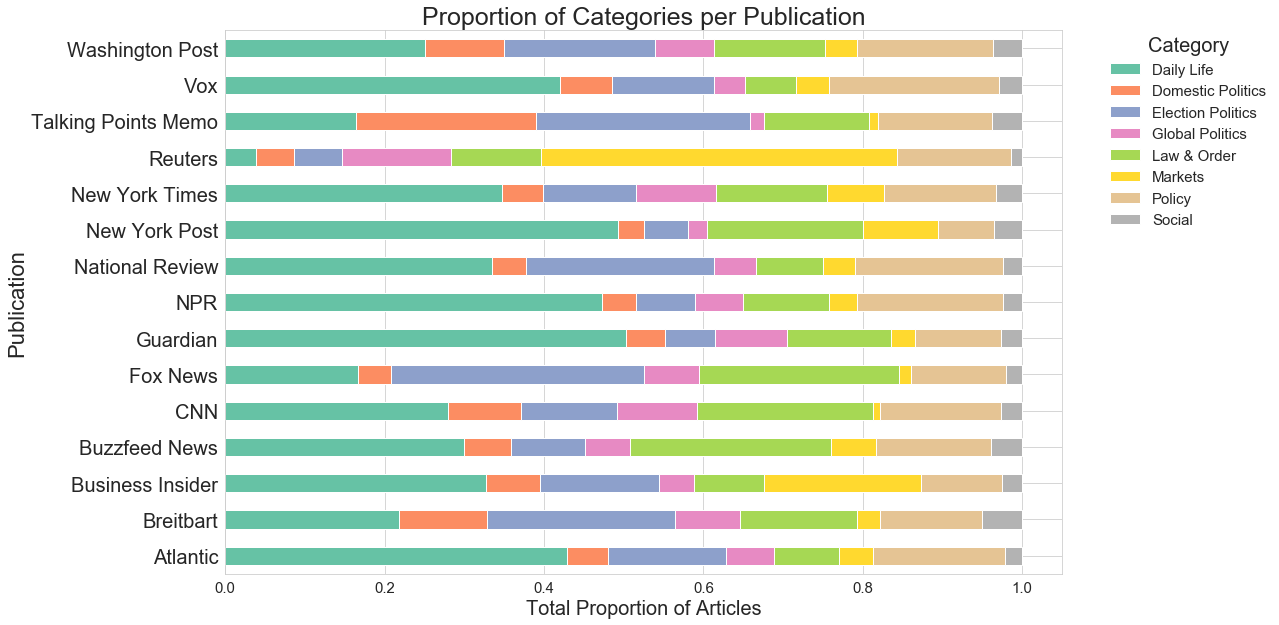

In [46]:
# Plot the categories per publication
cat_plot = cat_df.pivot(index = 'category', columns ='publication', values = 'rate').reset_index()
cat_plot.columns

plot_df = cat_plot.set_index('category').T

p = plot_df.plot(kind='barh', stacked=True, figsize =(15,10), fontsize = 15, colormap = 'Set2')

p.set_xlabel('Total Proportion of Articles', fontsize = 20)
p.set_ylabel('Publication', fontsize = 22)
p.set_title('Proportion of Categories per Publication', fontsize = 25)
p.set_yticklabels(labels = p.get_yticklabels(), fontsize = 20)

new_labels = ['Daily Life', 'Domestic Politics', 'Election Politics', 'Global Politics', 'Law & Order', 'Markets', 'Policy', 'Social']

plt.legend(labels = new_labels, title = 'Category', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., framealpha = 0, fontsize = 15)
p.get_legend().get_title().set_fontsize('20')

plt.savefig('Images/category_stacked_b.png', format="png", bbox_inches='tight', transparent = True, dpi = 300)

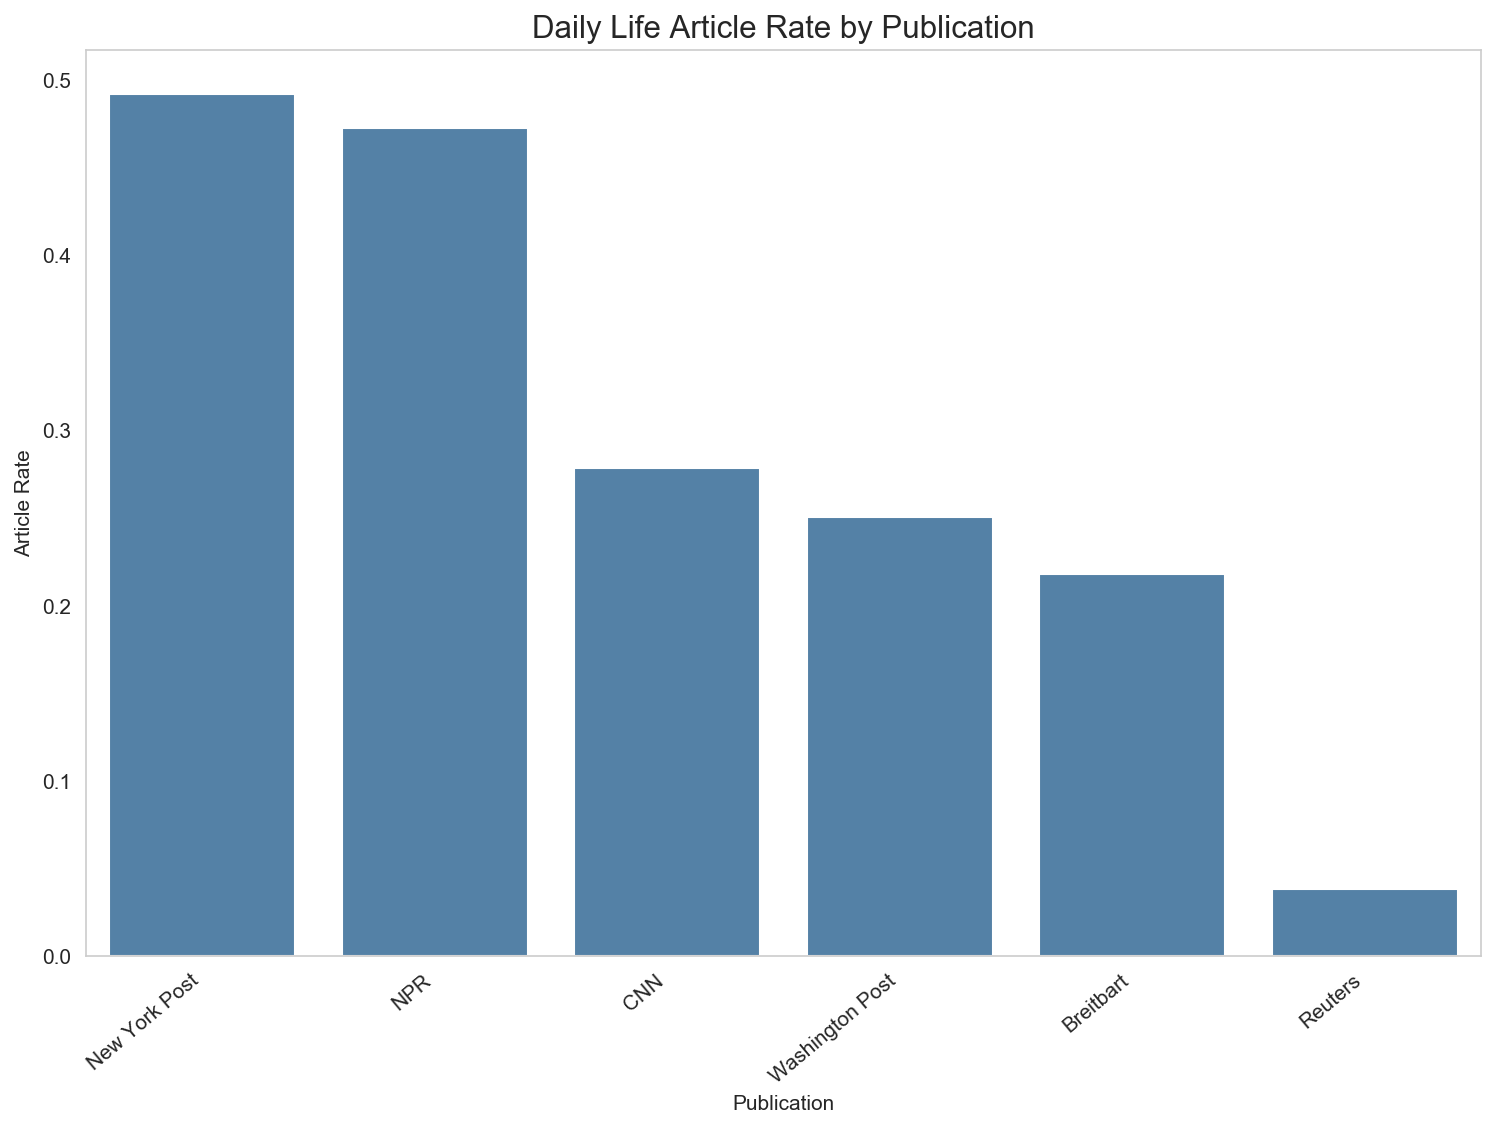

In [51]:
# Plot the rates for the daily life category
mask_daily = test_df['category'] == 'daily_life'

plot_data = test_df[mask_daily].sort_values('rate', ascending = False).head(6)

plt.figure(dpi = 150)
plt.rcParams['figure.figsize']=(12,8)

s = sns.barplot(x = 'publication', y = 'rate', data = plot_data, color = 'steelblue')
s.set_xlabel('Publication')
s.set_ylabel('Article Rate')
s.set_title('Daily Life Article Rate by Publication', fontsize = 15)
s.set_xticklabels(labels = s.get_xticklabels(), ha = 'right', rotation=40)
s.grid(False);

plt.savefig('Images/daily.png', format="png", bbox_inches='tight', transparent = True, dpi = 300)

### Additional Presentation Visualizations

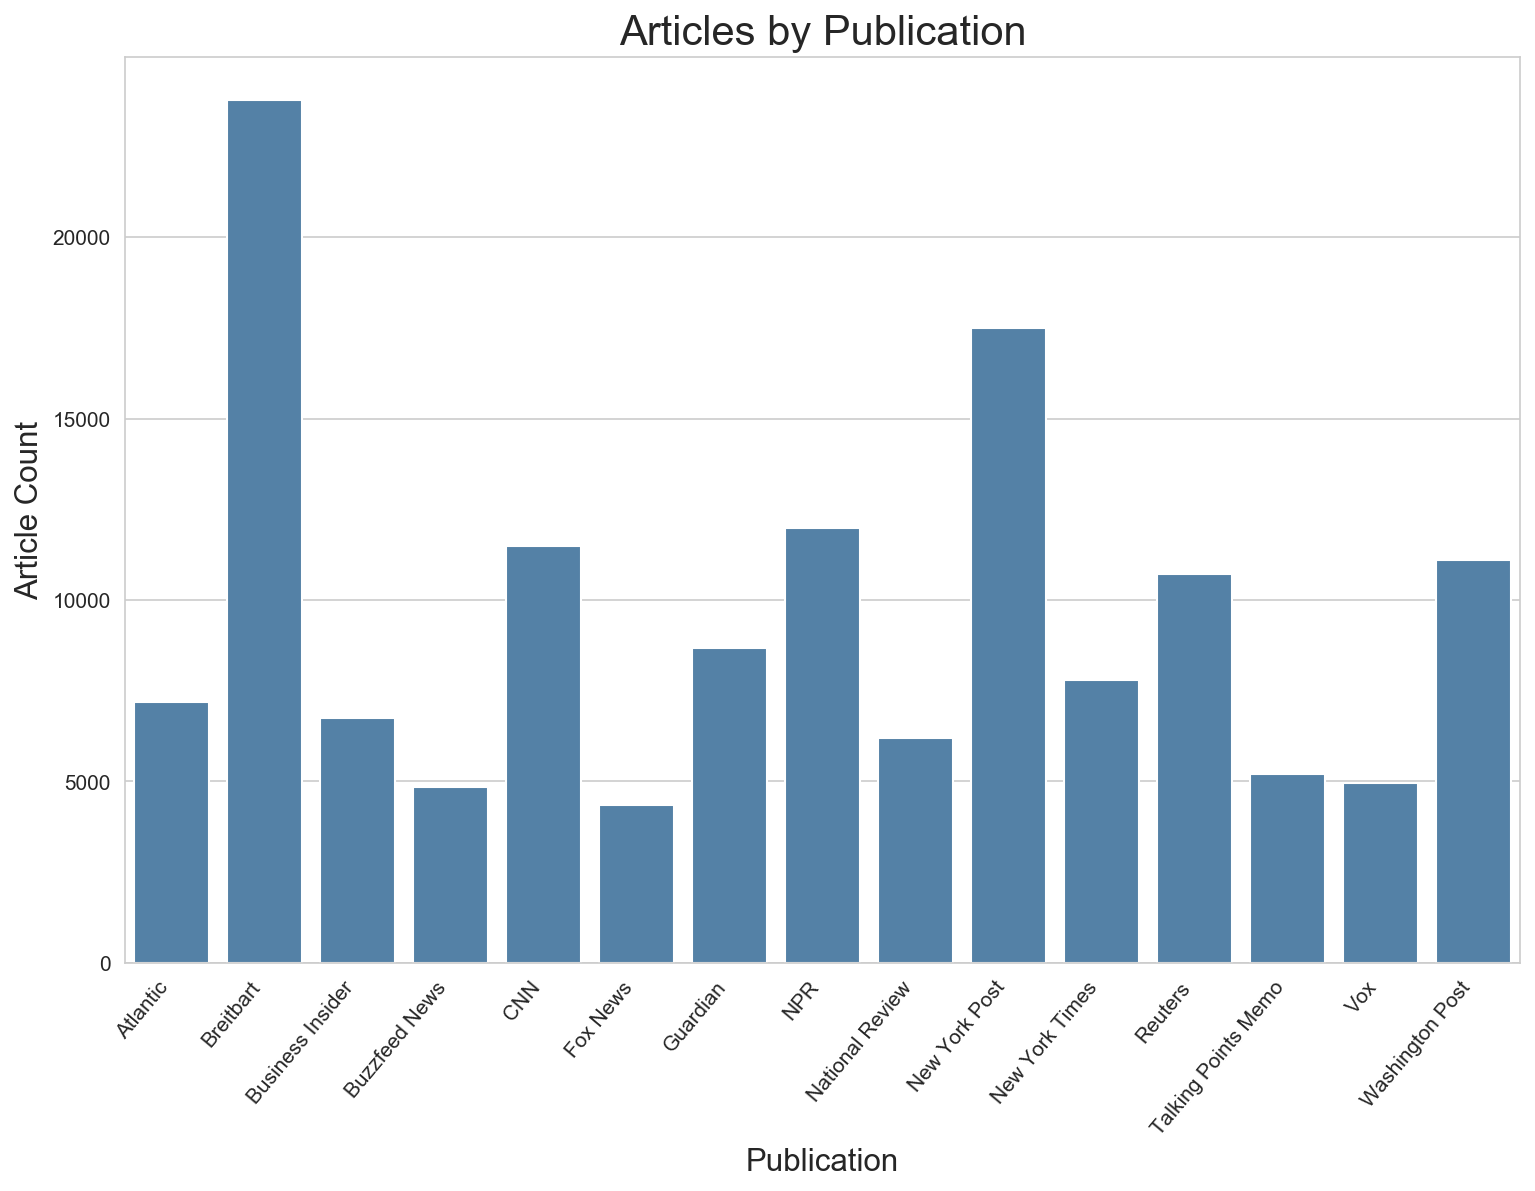

In [48]:
count_df = feature_df.groupby('publication')['id'].count().reset_index()

plt.figure(dpi = 150)
plt.rcParams['figure.figsize']=(10,5)

b = sns.barplot(x = 'publication', y = 'id', data=count_df, color = 'steelblue')
b.set_xticklabels(labels = b.get_xticklabels(), ha = 'right', rotation=50, fontsize = 10)
b.set_xlabel('Publication', fontsize =15)
b.set_ylabel('Article Count', fontsize = 15)
b.set_title('Articles by Publication', fontsize = 20);

plt.savefig('Images/overall.png', format="png", bbox_inches='tight', transparent = True, dpi = 300)

In [ ]:
# Note: settings below used to make color the plots for presentation only.
import matplotlib as mpl
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rc('axes',edgecolor=COLOR)